In [12]:
import pandas as pd
from IPython import display
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from collections import Counter, defaultdict
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect("game-log.sqlite", 2500)
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
pd.options.display.max_rows = 500
pd.options.display.precision = 2
plt.matplotlib.rcParams['figure.facecolor'] = "#fdf8ed"
plt.matplotlib.rcParams['axes.facecolor'] = (1,1,1,0)

In [13]:
pd.read_sql("""
select
    games.id, descA, descB, winner, datetime(date - 3600*5, 'unixepoch') start,
    format("%0.1f min ago", (unixepoch() - moves.time+1)/60) recent
from games
    left join moves on (games.id == moves.game)
group by moves.game having moves.time == max(moves.time)
order by date desc limit 30;
            """, conn, index_col='id', parse_dates='date')


,descA,descB,winner,start,recent
id,,,,,
744,od/100k,od/100k,,2024-02-02 07:37:51,0.6 min ago
743,hybridlog/100k,fast/100k,,2024-02-02 07:37:40,0.1 min ago
742,fast/100k,hybridlog/100k,,2024-02-02 07:37:22,0.1 min ago
741,od/100k,fastest/100k,,2024-02-02 07:36:22,2.1 min ago
740,hybridlog/10k,hybridlog/10k,A,2024-02-02 07:35:33,2.1 min ago
739,fastest/10k,hybrid/10k,B,2024-02-02 07:34:49,2.9 min ago
738,hybridlog/10k,fastest/100k,B,2024-02-02 07:26:35,3.7 min ago
737,fast/100k,odLog/100k,,2024-02-02 07:26:30,1.6 min ago
736,hybrid/10k,hybrid/10k,A,2024-02-02 07:25:35,11.9 min ago


In [14]:
games_df = pd.read_sql("select * from games where winner != '';", conn)
display.display(display.Markdown(f"# Summary: {len(games_df)} finished games"))
records = defaultdict(list)
for _, row in games_df.iterrows():
    records['id'].append(row.id)
    records['winner'].append(row['desc' + row.winner])
    records['loser'].append(row['desc' + {"A":"B","B":"A"}[row.winner]])
records = pd.DataFrame(records).set_index('id')
records['Pairwise win chart'] = 1
pairwise = records.groupby(['winner','loser']).sum().unstack().fillna(0).astype(int)
wins = pairwise.values
total = wins + wins.T
pairwise.insert(0, 'Total', total.sum(axis=1))
pairwise.insert(0, 'Win count', wins.sum(axis=1))
pairwise.insert(0, 'Win percent', pairwise['Win count']/pairwise['Total'])
elo = defaultdict(lambda: 1000)
for _ in range(10):
    for _, row in records.iterrows():
        player1 = row.winner
        player2 = row.loser
        r1 = 10 ** (elo[player1] / 400)
        r2 = 10 ** (elo[player2] / 400)
        e1 = r1 / (r1+r2)
        e2 = r2 / (r1+r2)
        elo[player1] += 32 * (1.0-e1)
        elo[player2] += 32 * (0.0-e2)
pairwise.insert(0, 'ELO', pd.Series(elo, name='elo').sort_values(ascending=False))
pairwise.sort_values('ELO', ascending=False)

# Summary: 722 finished games

ELO Win percent Win count Total Pairwise win chart  \
loser                                                        fast/100k   
winner                                                                   
od/100k         1256.78        0.72        80   111                  6   
fast/100k       1183.97        0.71        78   110                  8   
hybrid/100k     1159.03        0.68        75   110                  4   
od/10k          1126.20        0.61        59    96                  2   
fastest/100k    1111.66        0.60        74   124                  5   
odLog/100k      1090.35        0.69        84   122                  4   
odLog/10k       1038.70        0.46        65   140                  2   
hybrid/10k       917.79        0.47        61   129                  0   
fast/10k         911.04        0.40        50   126                  1   
hybridlog/100k   909.06        0.40        45   113                  0   
fastest/10k      727.41        0.26        34   133                  0   
hybridlog/10k    568.02        0.13        17   130                  0   

                                                                         \
loser          fast/10k fastest/100k fastest/10k hybrid/100k hybrid/10k   
winner                                                                    
od/100k               6            6           8           4          7   
fast/100k            12            5          12           3          6   
hybrid/100k          11            1          13           4         10   
od/10k                5            5           6           3          4   
fastest/100k          6            8           3           5          7   
odLog/100k            4            8           9           8          7   
odLog/10k             8            6          16           5          9   
hybrid/10k            7            3           9           0          7   
fast/10k              4            2           6           2          6   
hybridlog/100k        5            1           8           1          1   
fastest/10k           8            5           5           0          4   
hybridlog/10k         0            0           4           0          0   

                                                                       \
loser          hybridlog/100k hybridlog/10k od/100k od/10k odLog/100k   
winner                                                                  
od/100k                    11            10       4      7          4   
fast/100k                   4             7       4      5          6   
hybrid/100k                 6             7       4      6          3   
od/10k                      7             9       1      2          4   
fastest/100k               11            11       6      6          5   
odLog/100k                  9            15       4      4          3   
odLog/10k                   2             7       1      2          2   
hybrid/10k                  8            11       1      2          5   
fast/10k                    5             8       3      1          6   
hybridlog/100k              3            16       0      1          0   
fastest/10k                 2             5       2      1          0   
hybridlog/10k               0             7       1      0          0   

                          
loser          odLog/10k  
winner                    
od/100k                7  
fast/100k              6  
hybrid/100k            6  
od/10k                11  
fastest/100k           1  
odLog/100k             9  
odLog/10k              5  
hybrid/10k             8  
fast/10k               6  
hybridlog/100k         9  
fastest/10k            2  
hybridlog/10k          5

In [15]:
display.display(display.Markdown("## Total matchups (symmetric)"))
total = pd.DataFrame(pairwise['Pairwise win chart'].values + pairwise['Pairwise win chart'].T.values,
             index=pairwise.index,
             columns=pairwise['Pairwise win chart'].columns).rename_axis('').rename_axis('', axis=1)
display.display(total)
missing=[]
display.display(display.Markdown("## Matchups with less than 5 games"))
for a, row in total.iterrows():
    for b in total.columns[row < 5]:
        missing.append((a, b, total.loc[a,b]))
pd.DataFrame(missing, columns=['A','B','total games']).sort_values('total games')


## Total matchups (symmetric)

,fast/100k,fast/10k,fastest/100k,fastest/10k,hybrid/100k,hybrid/10k,hybridlog/100k,hybridlog/10k,od/100k,od/10k,odLog/100k,odLog/10k
,,,,,,,,,,,,
fast/100k,16,13,10,12,7,6,4,7,10,7,10,8
fast/10k,13,8,8,14,13,13,10,8,9,6,10,14
fastest/100k,10,8,16,8,6,10,12,11,12,11,13,7
fastest/10k,12,14,8,10,13,13,10,9,10,7,9,18
hybrid/100k,7,13,6,13,8,10,7,7,8,9,11,11
hybrid/10k,6,13,10,13,10,14,9,11,8,6,12,17
hybridlog/100k,4,10,12,10,7,9,6,16,11,8,9,11
hybridlog/10k,7,8,11,9,7,11,16,14,11,9,15,12
od/100k,10,9,12,10,8,8,11,11,8,8,8,8


## Matchups with less than 5 games

,A,B,total games
0,fast/100k,hybridlog/100k,4
1,hybridlog/100k,fast/100k,4
2,od/10k,od/10k,4


# Evaluation speed

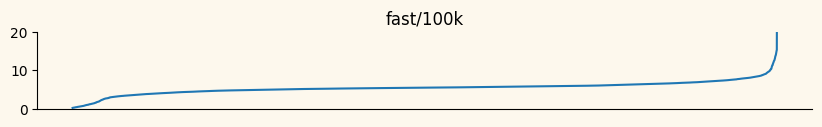

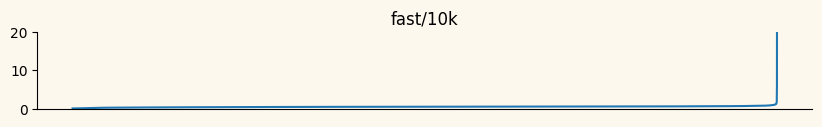

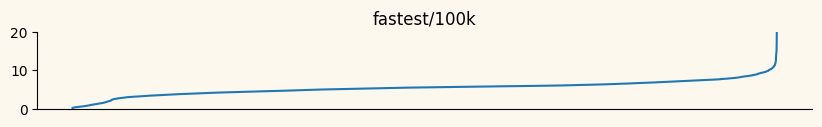

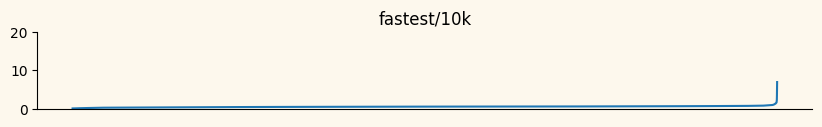

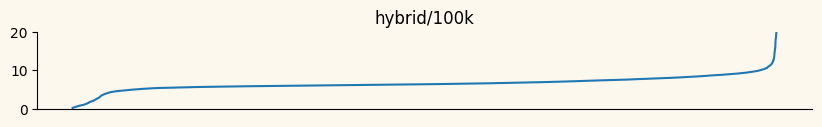

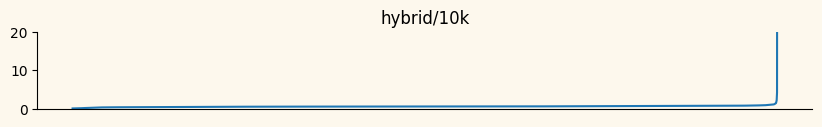

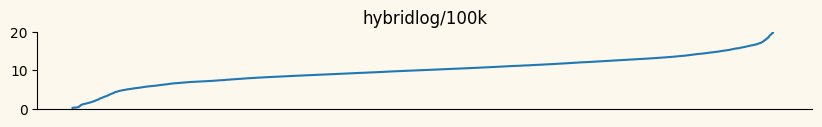

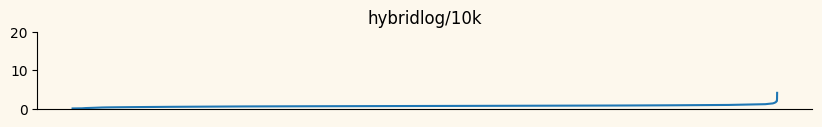

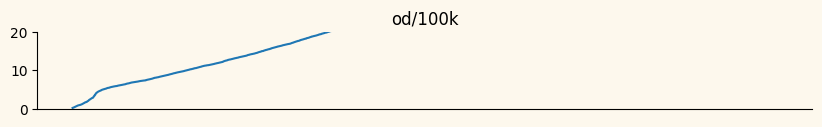

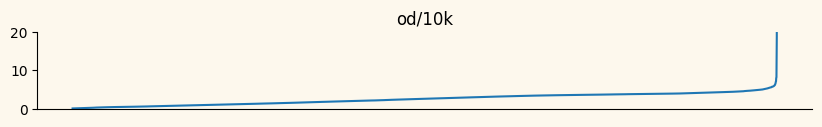

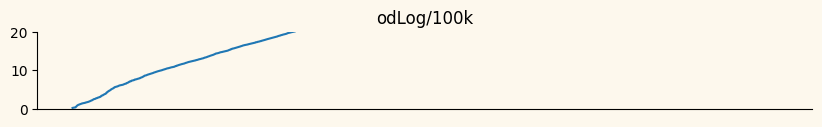

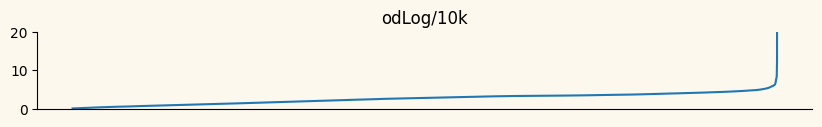

In [16]:
df = pd.read_sql("""
with descriptions as (
    select id, descA desc, "A" player from games union all select  id, descB, "B" from games
) select desc, thinkDuration from moves
inner join descriptions on (moves.game == descriptions.id and moves.player == descriptions.player)
where 0 < thinkDuration and thinkDuration < 60.0
""", conn).groupby('desc')
df.describe()
for desc, times in df.apply(lambda x: x.thinkDuration.tolist()).items():
    fig,ax = plt.subplots(figsize=(10, 1))
    ax.spines[['top','right']].set_visible(False)
    ax.plot(sorted(times))
    ax.set(xticks=[],title=desc,ylim=(0,20))